# 第14章 パラメータ推定への応用と拡張（EnKF）

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

#### 乱数シードの指定（テキスト掲載用）
拙著に掲載の標本路を再現するため，シードを明示しておきます．本来は必要ないので，コメントアウトしてもいいです．

In [2]:
np.random.seed(123)

## 本章の共通設定

In [3]:
import Ch14_common as my
for line in open('Ch14_common.py'): print(line[:-1])

import numpy as np
import matplotlib.pyplot as plt

### デフォルト値
default_values = ( #Q, R, C, D, x0, dt, tn, p_list
    np.diag([0.0001,0.0001]), #Q:  システム雑音の共分散
    np.array([[0.0001]]),     #R:  観測雑音の共分散
    np.array([[1, 0]]),       #C:  変位のみ
    np.eye(2),                #D:  駆動行列
    np.array([0.0, 0.0]),     #x0: 初期値
    0.02,                     #dt: 時間ステップ
    2000,                     #tn: 時系列長
    [1, 0.2, 1],              #p_list: k, c, a
)

### 外部励振
def Forcing(t):
    return np.sin(1.5*t)

### 拡大系の導出
def get_extended_system(x0, Q, D, C, A=None, Qval=1.2):
        
    ex0 = np.append(x0, [0.0])
    # 拡大系
    if A is not None:
        eA = np.pad(A, (0,1), 'constant') #Aを1行1列拡大して0で埋める
        eA[-2,-1] = 1 #必要箇所に1を代入する
    else:
        eA = None
    # 推定パラメータにもシステム雑音を仮定（無いと推定パラメータが動かなくなる）
    eD = np.pad(D, (0,1), 'constant')
    eD[-1,-1] = 1
    # 推定パラメータは観測できないとする
    eC = np.pad(C, (0,1), 'constant')
    eC = np.delete(eC, axis=0, obj=-1)
    # 推定パラメータ用のシステム雑音強度を追加
    e

### 標本路の取得テスト

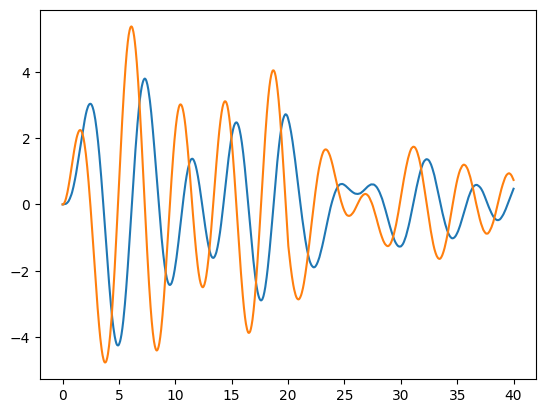

In [4]:
sim = my.model_1dof_tv(p_idx=2, p1=3, p2=1)
sim.get_sample_path()
plt.plot(sim.tt, sim.xx)

## 14.3 アンサンブルカルマンフィルタ

### 算法14.2 (EnKF)

In [5]:
from class_EnKF import *
for line in open('class_EnKF.py'): print(line[:-1])

import numpy as np
from scipy.integrate import ode

class class_EnKF: #アンサンブルカルマンフィルタ(Ensemble Kalman filter)

    def __init__(self, xdim, ydim, Q, R, pn):

        ### システムのサイズ
        self.xdim = xdim #状態の次元
        self.ydim = ydim #観測の次元
        self.pn   = pn   #アンサンブルの粒子数

        ### 雑音
        self.Q    = np.array(Q)         #システム雑音の共分散
        self.wdim = self.Q.shape[0]     #システム雑音の次元
        self.w    = np.zeros(self.wdim) #システム雑音ベクトル
        self.wav  = np.zeros(self.wdim) #システム雑音の平均 = 0

        self.R    = np.array(R)         #観測雑音の共分散
        self.vdim = self.R.shape[0]     #観測雑音の次元
        self.v    = np.zeros(self.vdim) #観測雑音ベクトル
        self.vav  = np.zeros(self.vdim) #観測雑音の平均 = 0
        
        ### アンサンブル行列
        self.Xp = np.zeros((self.xdim, self.pn))  #予測推定アンサンブル
        self.Xf = np.zeros_like(self.Xp)          #濾波アンサンブル
        self.Yp = np.zeros((self.ydim, self.pn))  #予測出力アンサンブル
        self.ones = np.ones((self.pn,1))
        
        self.bias = self.pn

### 数値例作成用のクラス

In [6]:
import matplotlib.gridspec as gsp
import time

class EnKF_param(class_EnKF):
    
    def __init__(s, pn, x0, P0, Qval):

        Q, R, C, D, _x0, dt, tn, p_list = my.default_values
        _x0, Q, D, C, = my.get_extended_system(_x0, Q, D, C, Qval=Qval)

        s.dt = dt                 #時間ステップ
        s.C = C
        s.D = D*np.sqrt(s.dt)     #離散時間近似のため(算法12.3)
        s.p_list = p_list.copy()
        xdim = len(x0);           #状態ベクトルの次元
        ydim = C.shape[0]         #出力ベクトルの次元
        
        s.pn = pn
        super().__init__(xdim, ydim, Q, R, s.pn)

        x0 = np.array(x0)      #初期値
        P0 = np.diag(P0)
        s.system_definition(s.F_func, s.H_func, x0, P0)
        
        s.k, s.c, s.a = s.p_list
           
    def H_func(s, x):
        y = s.C.dot(x)
        return y

    def get_example(s, p_idx, p1, p2):
        target = my.model_1dof_tv(p_idx, p1, p2)
        target.get_sample_path()
        s.tt = target.tt
        s.xx = target.xx
        s.param = target.param
        s.xxf = np.zeros((len(target.tt),3))

        start = time.time()
        for i, y in enumerate(target.yy):
            s.xxf[i] = s.xf
            s.filtering(y, s.tt[i])
            s.prediction()
        elapsed_time = time.time() - start
        
        return elapsed_time
            
    def get_example_with_snapshot(s, p_idx, p1, p2):
        target = my.model_1dof_tv(p_idx, p1, p2)
        target.get_sample_path()
        s.tt = target.tt
        s.xx = target.xx
        s.param = target.param
        s.xxf = np.zeros((len(target.tt),3))
        s.XpSet = []
        s.meanXpSet = []
        for i, y in enumerate(target.yy):
            s.filtering(y, s.tt[i], skip_prediction=True)
            s.xxf[i] = s.xf
            s.XpSet.append(s.Xp)
            s.meanXpSet.append(s.meanXp)
            s.prediction()

    def plot(s):
        fig = plt.figure(figsize=(5, 4))
        gs = gsp.GridSpec(2,2)
        ax1 = fig.add_subplot(gs[0,:])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
        for i, t in enumerate(s.tt):
            if i%5 == 0:
                Xp = s.XpSet[i]
                meanXp = s.meanXpSet[i]
                ax3.plot(Xp[0,:],Xp[1,:],'k.',markersize=0.5,alpha=0.7)
                ax3.plot(meanXp[0],meanXp[1],'r.',markersize=3,alpha=0.7)
    
        ax1.plot(s.tt, s.xxf[:,2], label='filtered'); ax1.grid()
        ax2.plot(s.xxf[:,0], s.xxf[:,1], label='filtered')
        ax2.plot(s.xx[:,0], s.xx[:,1], label='original')
        ax2.legend()
        plt.tight_layout()

In [7]:
Elapsed_Times = []

### 線形と同じaの同定

《著者PC参考》
```
CPU times: user 59.1 s, sys: 672 µs, total: 59.1 s
Wall time: 59.1 s
```

In [8]:
%%time
class EnKF_a(EnKF_param):
    
    def __init__(s, pn, x0, P0, Qval):
        
        super().__init__(pn, x0, P0, Qval)

    def F_func(s, x, t):
        ff = np.array([
            x[1],
            - s.k*x[0] - s.c*x[1] + x[2]*my.Forcing(t),
            0
        ])

        Dw = np.ravel(s.D.dot(s.w))
        x1 = x + s.dt*ff + Dw 

        return x1
    
np.random.seed(123)
enkf_a = EnKF_a(pn=100, x0=[0.0, 0.0, 0.0], P0=[0.0001, 0.0001, 0.01], Qval=0.001)
etim = enkf_a.get_example(p_idx=2, p1=3, p2=1)
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.001 ]]
CPU times: total: 1min 16s
Wall time: 1min 19s


[[-0.00035159  0.00081842 -0.01342414]
 [-0.00495519  0.00172554 -0.00237785]
 [-0.00397216  0.00194999 -0.00030509]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


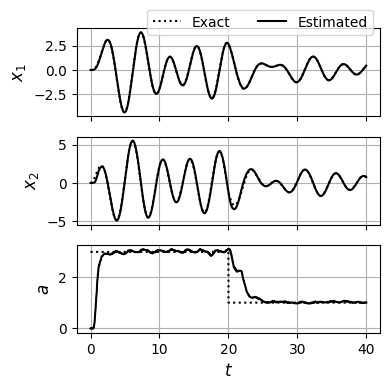

In [9]:
print(enkf_a.xxf[:3,:])
my.plot(enkf_a,'$a$')
my.save('figs/Ch14-EnKF-a.eps')

### 線形では解けないkの同定

In [10]:
class EnKF_k(EnKF_param):
    
    def __init__(s, pn, x0, P0, Qval):       
        super().__init__(pn, x0, P0, Qval)

    def F_func(s, x, t):
        
        ff = np.array([
            x[1],
            - (x[2])*x[0] - s.c*x[1] + s.a*my.Forcing(t),
            0
        ])

        Dw = np.ravel(s.D.dot(s.w))
        x1 = x + s.dt*ff + Dw

        return x1

np.random.seed(123)
enkf_k = EnKF_k(pn=100, x0=[0.0, 0.0, 0.0], P0=[0.0001, 0.0001, 0.00001], Qval=0.0005)
etim = enkf_k.get_example(p_idx=0, p1=0.5, p2=1.0) #kを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0005]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


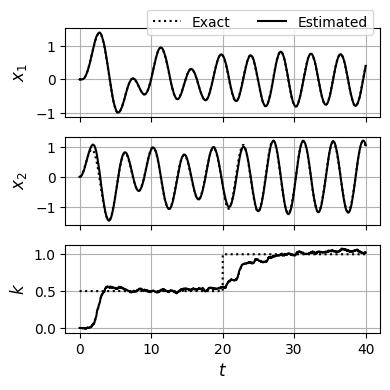

In [11]:
my.plot(enkf_k,'$k$')
my.save('figs/Ch14-EnKF-k.eps')

### 線形では解けないｃの同定

In [12]:
class EnKF_c(EnKF_param):
    
    def __init__(s, pn, x0, P0, Qval):
        super().__init__(pn, x0, P0, Qval)

    def F_func(s, x, t):
        
        x[2] = np.abs(x[2]) #減数係数はプラス
        
        ff = np.array([
            x[1],
            - s.k*x[0] - (x[2])*x[1] + s.a*my.Forcing(t),
            0
        ])

        Dw = np.ravel(s.D.dot(s.w))
        x1 = x + s.dt*ff + Dw

        return x1

np.random.seed(123)
enkf_c = EnKF_c(pn=100, x0=[0.0, 0.0, 0.0], P0=[0.0001, 0.0001, 0.01], Qval=0.0003)
etim = enkf_c.get_example(p_idx=1, p1=0.5, p2=1.0) #cを変化させる
Elapsed_Times.append(etim)

Extended x0 =
 [0. 0. 0.]
Extended A =
 None
Extended D =
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Extended C =
 [[1 0 0]]
Extended Q =
 [[0.0001 0.     0.    ]
 [0.     0.0001 0.    ]
 [0.     0.     0.0003]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


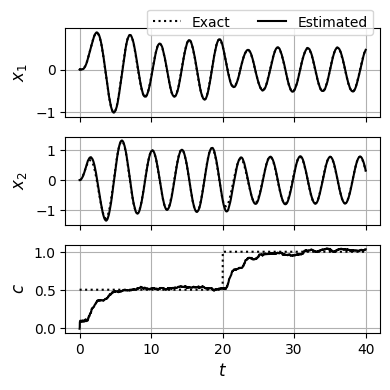

In [13]:
my.plot(enkf_c,'$c$')
my.save('figs/Ch14-EnKF-c.eps')

In [14]:
print(Elapsed_Times)

[78.50955963134766, 75.29533910751343, 78.1685836315155]
